In [1]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_INCEPTION = True

In [2]:
image_folder="/home/shreyansh/repo/Image-Caption/data/Images/*.jpg"
trainImages_txt='/home/shreyansh/repo/Image-Caption/data/Flickr_8k.trainImages.txt'
testImages_txt='/home/shreyansh/repo/Image-Caption/data/Flickr_8k.testImages.txt'
token_txt='/home/shreyansh/repo/Image-Caption/data/Flickr8k.token.txt'
model_file="/home/shreyansh/repo/Image-Caption/data/caption-model.hdf5"
imageToTest='/home/shreyansh/repo/Image-Caption/imgs/download (1).jpeg'

Encodeimage


In [4]:
if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = \
    tensorflow.keras.applications.inception_v3.preprocess_input
else:
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

In [5]:
def encodeImage(img):

  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  x = encode_model.predict(x)
  x = np.reshape(x, OUTPUT_DIM )
  return x

generateCaption


In [6]:
img= glob.glob(image_folder)

In [7]:
train_images_path = os.path.join('',\
            trainImages_txt) 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join('',
            testImages_txt) 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f)

In [8]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open(token_txt, 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]

In [9]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' \
                      in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

In [10]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [11]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

In [12]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

In [13]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

Caption Model



In [14]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 200, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [15]:
caption_model.load_weights(model_file)

NameError: name 'caption_model' is not defined

Final


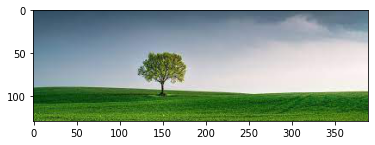

(1, 2048)
Caption: man in blue shirt and jeans is walking down the road
_____________________________________


In [17]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

%matplotlib inline





img = Image.open(imageToTest)
img.load()

plt.imshow(img)
plt.show()
  


img = encodeImage(img).reshape((1,OUTPUT_DIM))
print(img.shape)
print("Caption:",generateCaption(img))
print("_____________________________________")